In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
from IPython.display import display

In [ ]:
def set_random_seeds(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_random_seeds()

In [ ]:
def load_images_from_directory(directory, target_size=(256, 256)):
    images = []
    labels = []
    for label in os.listdir(directory):
        class_folder = os.path.join(directory, label)
        if os.path.isdir(class_folder):
            for image_filename in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_filename)
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image = load_img(image_path, target_size=target_size)
                    image = img_to_array(image) / 255.0  # Normalize the images
                    images.append(image)
                    labels.append(label)
    return np.array(images), np.array(labels)


In [ ]:
train_dir = '/content/drive/MyDrive/Dissertation/Dataset/Train'
valid_dir = '/content/drive/MyDrive/Dissertation/Dataset/Valid'
test_dir = '/content/drive/MyDrive/Dissertation/Dataset/Test'

X_train, y_train = load_images_from_directory(train_dir)
X_valid, y_valid = load_images_from_directory(valid_dir)
X_test, y_test = load_images_from_directory(test_dir)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_valid_encoded = to_categorical(label_encoder.transform(y_valid))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train_encoded, batch_size=32)
valid_generator = valid_datagen.flow(X_valid, y_valid_encoded, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test_encoded, batch_size=32)


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(y_train_encoded.shape[1], activation='softmax')  # Use the shape of the encoded labels
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]
)


Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 0.9737 - accuracy: 0.5089

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 218s 7s/step - loss: 0.9737 - accuracy: 0.5089 - val_loss: 0.6665 - val_accuracy: 0.7333
Epoch 2/20
29/29 [==============================] - 228s 8s/step - loss: 0.6928 - accuracy: 0.6822 - val_loss: 0.5984 - val_accuracy: 0.7033
Epoch 3/20
29/29 [==============================] - 221s 8s/step - loss: 0.6003 - accuracy: 0.7089 - val_loss: 0.4720 - val_accuracy: 0.7600
Epoch 4/20
29/29 [==============================] - 223s 8s/step - loss: 0.5018 - accuracy: 0.7833 - val_loss: 0.3812 - val_accuracy: 0.8400
Epoch 5/20
29/29 [==============================] - 222s 8s/step - loss: 0.4474 - accuracy: 0.8111 - val_loss: 0.3194 - val_accuracy: 0.8567
Epoch 6/20
29/29 [==============================] - 217s 7s/step - loss: 0.3571 - accuracy: 0.8544 - val_loss: 0.3834 - val_accuracy: 0.8367
Epoch 7/20
29/29 [==============================] - 224s 8s/step - loss: 0.3191 - accuracy: 0.8767 - val_loss: 0.4180 - val_accuracy: 0.8233
Epoch 8/20
29/29 [======

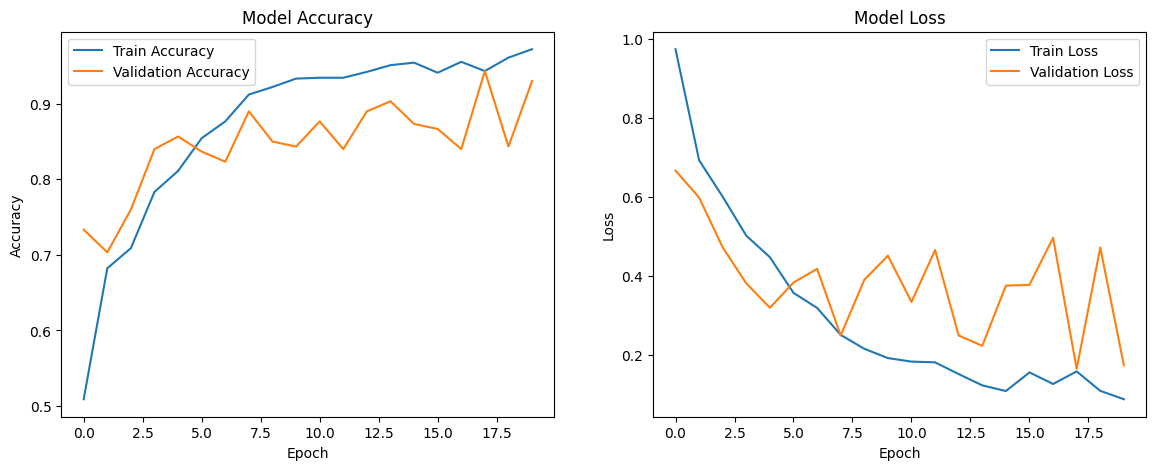

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
evaluation = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

10/10 [==============================] - 15s 1s/step - loss: 0.1098 - accuracy: 0.9500
Test Loss: 0.1098327785730362, Test Accuracy: 0.949999988079071


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Dissertation/model.h5')

In [ ]:
from IPython.display import Image, display
from google.colab import files
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array

def predict_with_confidence(model, image_path, class_labels, threshold=0.75):
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    confidence = np.max(predictions)
    predicted_class_idx = np.argmax(predictions)
    if confidence < threshold:
        return "Low confidence in prediction.", confidence
    else:
        predicted_label = class_labels[predicted_class_idx]
        return predicted_label, confidence

def upload_and_predict(model, class_labels):
    uploaded = files.upload()
    for fn in uploaded.keys():
        display(Image(fn))
        predicted_label, confidence = predict_with_confidence(model, fn, class_labels)
        print(f"Uploaded image: {fn}. Predicted class: {predicted_label}, Confidence: {confidence:.2f}%")

# Load Model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Dissertation/model.h5')
class_labels = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Call the function to upload images and get predictions
upload_and_predict(loaded_model, class_labels)
